**Hey, everyone!** \
Notebook represents the realization of T5-multitask model for translation of scientific works titles. This model led my team to the 3-rd place in the FIC (Innovation Centers Forum) 2024.\
Let's move on to the introduction

# Task statement
To train the model for the most relevant translation, taking into account the additional features that we have at our disposal.

# Realization
The key point in this task is to use additional categorical data (faculty, direction) to improve the translation of the model. Despite the fact that a pre-trained translator shows excellent results on the BERT-score metric, the BLEU metric barely gets to 0.5. This is due to the fact that the academic field requires its own features for translation. For example, word order plays an important role, which does not take into account a model that is not specialized for this task, unlike the BLEU metric (BERT-score, in turn, looks only at semantic similarity, therefore it is high for both models). This is why there is such a big difference. It is the additional data that will help the model better understand the terms specific to each of the areas. Therefore, it is very important to use categorical features correctly. Guided by these considerations, I settled on the T5-multitask model. Using the pre-trained T5 model on the task of translating from Russian to English from google, I have completed it on three tasks:

1. Translating training data
2. Classification of the faculty
3. Classification of the field of work
   
This approach uses each article title several times. This allows you to update the model parameters from different angles: the model finds connections between all the features. At the same time, an important feature of my implementation is the following: since by the condition of the task we need a translation task, I take into account the influence of three tasks with different coefficients. This is an extremely powerful hyperparameter that can greatly influence the final result. As a result, we get a model not only with a more accurate translation for this field, but also a model capable of performing two additional tasks: the classification of the faculty and the directions according to the title of the article.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu # Used metrics
from bert_score import score # Used metrics
from torch.utils.data import Dataset, DataLoader # DataLoader for faster training
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW # It will help us with the pretrained model

# Reading data

In [3]:
train_df = pd.read_excel('train.xlsx')
train_df.head()

,name,translation,faculty,direction
0,Строение и история развития отложений Мамонто...,Mamontova Gora (the Aldan River): the structur...,Геологический факультет,Науки о Земле
1,"""Hortulus animae"" как особый тип печатного час...","""Hortulus animae"" as a special type of “The Bo...",Исторический факультет,Политические науки и регионоведение; Историчес...
2,"""NHK для школы"" как образовательный проект япо...","""NHK for school"" as an educational project of ...",Факультет журналистики,Средства массовой информации и информационно-б...
3,"""Tavola ritonda"" из Национальной библиотеки Фл...","""Tavola ritonda"" from the National Library in ...",Исторический факультет,Политические науки и регионоведение; Историчес...
4,"""War and peace"" novel by Leo Tolstoy in Chines...",Juxtaposition of zoonyms in the discourse of ...,Высшая школа перевода,Языкознание и литературоведение


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70325 entries, 0 to 70324
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         70325 non-null  object
 1   translation  70325 non-null  object
 2   faculty      70325 non-null  object
 3   direction    70325 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [5]:
test_df = pd.read_excel('test.xlsx')
test_df.head()

,name,faculty,direction
0,Интегрированные маркетинговые коммуникации в п...,Факультет журналистики,Средства массовой информации и информационно-б...
1,Влияние света на взаимодействие белков в корне...,Биологический факультет,Биологические науки
2,Расчет вероятности двухфотонного поглощения ко...,Химический факультет,Химические науки; Биологические науки
3,Использование временных форм русского глагола ...,Филологический факультет,Образование и педагогические науки; Языкознани...
4,Склонность человека к риску как фактор адаптац...,Экономический факультет,Экономика


# Preprocessing

In [6]:
train_df.shape, test_df.shape

((70325, 4), (200, 3))

In [9]:
print(f'The number of faculties in the training and test samples, respectively: {len(train_df['faculty'].unique()), len(test_df['faculty'].unique())}')
print(f'The number of directions in the training and test samples, respectively: {len(train_df['direction'].unique()), len(test_df['direction'].unique())}')

The number of faculties in the training and test samples, respectively: (35, 34)
The number of directions in the training and test samples, respectively: (29, 28)


In [10]:
#This faculty doesn't appear in the test set, but I left him due to the little amount of data
set(train_df['faculty']) - set(test_df['faculty'])

{'Высшая школа культурной политики и управления в гуманитарной сфере'}

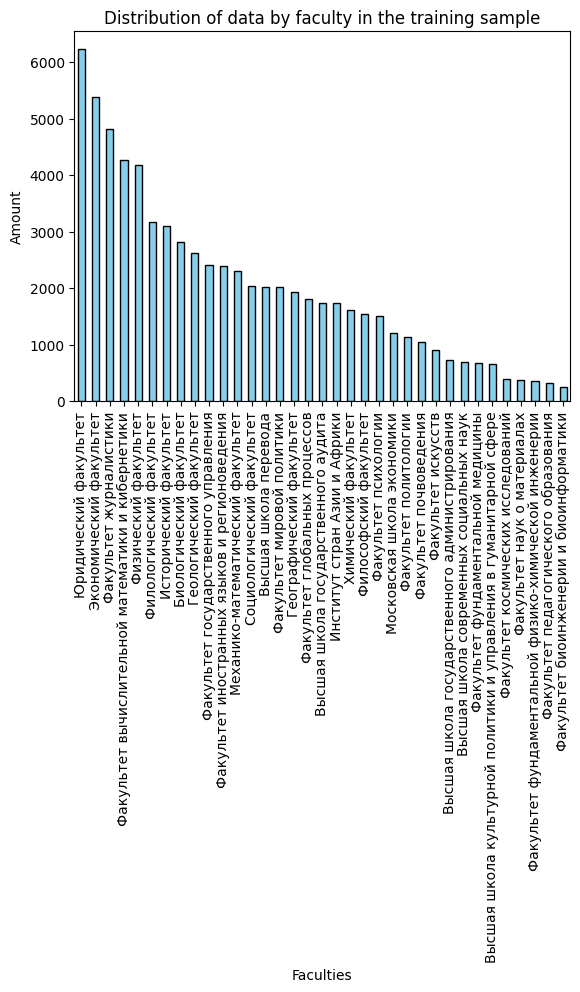

In [12]:
faculty_counts = train_df['faculty'].value_counts()
faculty_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of data by faculty in the training sample')
plt.xlabel('Faculties')
plt.ylabel('Amount')
plt.show()

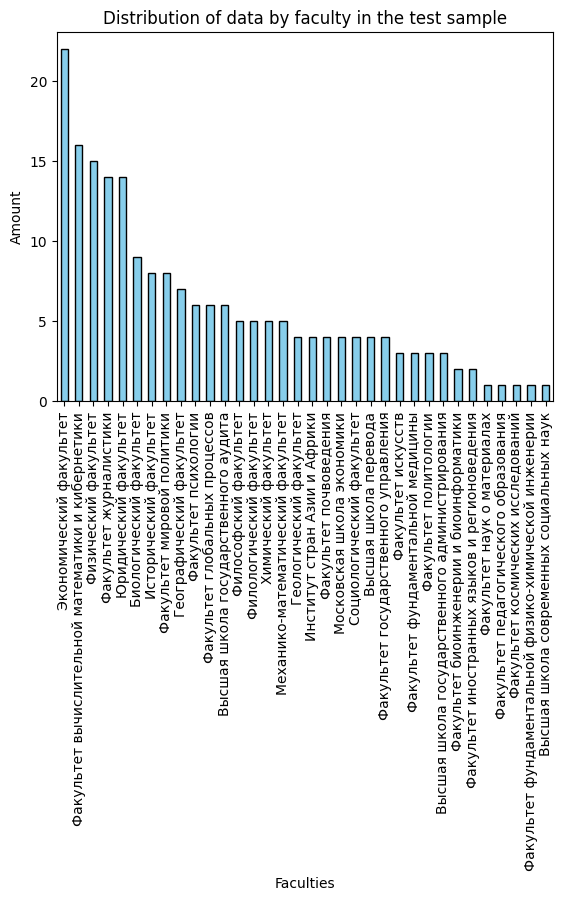

In [13]:
faculty_counts = test_df['faculty'].value_counts()
faculty_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of data by faculty in the test sample')
plt.xlabel('Faculties')
plt.ylabel('Amount')
plt.show()

In [14]:
# Removing duplicate values in the translation column
train_df = train_df.drop_duplicates(subset="translation")
train_df.shape

(64048, 4)

In [15]:
# Deleting rows where the ratio of the number of words in the first two columns is > 2
train_df['src_count'] = train_df['name'].apply(lambda x: len(x.split()))
train_df['dst_count'] = train_df['translation'].apply(lambda x: len(x.split()))

train_df = train_df[train_df['src_count'] / train_df['dst_count'] < 2]
train_df = train_df[train_df['dst_count'] / train_df['src_count'] < 2]

train_df = train_df.drop(columns=['src_count', 'dst_count'])
train_df.shape

(62979, 4)

In [16]:
# Deleting rows, where the title of work doesn't consist of russian symbols
# And we clean up the titles of scientific papers a little
regex = '[а-яА-Я]'
train_df['name'] = train_df['name'].str.replace(r'^(\.|\)|)', '', regex=True)
train_df['name'] = train_df['name'].str.lstrip()
train_df = train_df[train_df['name'].str.contains(regex, regex=True)]
train_df.shape

(62922, 4)

In [17]:
# Creating a validation sample
MSU_val_df = train_df.sample(n=1000, random_state=20)
train_df.drop(MSU_val_df.index, inplace=True)
train_df.shape

(61922, 4)

In [18]:
MSU_val_df.head()

,name,translation,faculty,direction
66815,Характеризация свойства свободной порожденност...,Characterization of free generatedness for the...,Механико-математический факультет,Математика и механика; Информатика и вычислите...
43357,Притяжательные прилагательные в Киевской и Нов...,Possessive adjectives in the Kievan and Novgor...,Филологический факультет,Образование и педагогические науки; Языкознани...
53786,Совершенствование музейного менеджмента как ре...,Improving museum management as a resource for ...,Высшая школа культурной политики и управления ...,Политические науки и регионоведение; Культурол...
48938,Редакторская оценка медиапроекта Curious.ru,Editorial assessment of the Curious.ru media p...,Факультет журналистики,Средства массовой информации и информационно-б...
17364,Исследование истории разработки эксплуатационн...,Studying the development history of a producti...,Геологический факультет,Науки о Земле


# Preparing data for training: creating a DataLoader, analyzing parameters, loading a pretrained model

In [20]:
X_train = []
# With the help of prefixes, the model learns to solve several problems at once
translate_prefix = 'translate ru-en: ' # The prefix for the translation task
faculty_classification_prefix = 'classify_faculty: ' # The prefix for the task of defining the faculty
direction_classification_prefix = 'classify_direction: ' # The prefix for the task of determining the direction

for i in range(len(train_df)):
    row = train_df.iloc[i]
    src = row['name']
    
    translate_src = translate_prefix + src
    translate_label = row['translation']
    
    faculty_src = faculty_classification_prefix + src
    faculty_label = row['faculty']
    
    direction_src = direction_classification_prefix + src
    direction_label = row['direction']
    
    X_train.append((translate_src, translate_label, faculty_src, faculty_label, direction_src, direction_label))

In [21]:
X_train[:3]

[('translate ru-en: Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Mamontova Gora (the Aldan River): the structure and history of deposits',
  'classify_faculty: Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Геологический факультет',
  'classify_direction: Строение и история развития отложений Мамонтовой горы (река Алдан)',
  'Науки о Земле'),
 ('translate ru-en: "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  '"Hortulus animae" as a special type of “The Book of Hours” in 16th century Europe',
  'classify_faculty: "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  'Исторический факультет',
  'classify_direction: "Hortulus animae" как особый тип печатного часослова в Европе XVI века',
  'Политические науки и регионоведение; Исторические науки и археология; Искусствоведение'),
 ('translate ru-en: "NHK для школы" как образовательный проект японского телевидения',
  '"NHK for school" as an

**Download of the pre-trained google-mt5-base model, specific in Russian, English\
Link to the HF:**
\
https://huggingface.co/cointegrated/rut5-base-multitask

In [23]:
tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-multitask")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [24]:
#Sentence length analysis
token_lengths = [len(tokenizer.encode(sentence)) for sentence , _, _, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, sentence, _, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, sentence, _, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, sentence, _, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, _, sentence, _ in X_train]
token_lengths += [len(tokenizer.encode(sentence)) for _, _, _, _, _, sentence in X_train]

mean_token_length = np.mean(token_lengths)
median_token_length = np.median(token_lengths)
max_token_length = np.max(token_lengths)
min_token_length = np.min(token_lengths)
std_token_length = np.std(token_lengths)

print(f"Mean Token Length: {mean_token_length}")
print(f"Median Token Length: {median_token_length}")
print(f"Max Token Length: {max_token_length}")
print(f"Min Token Length: {min_token_length}")
print(f"Std Token Length: {std_token_length}")

Mean Token Length: 22.39158672738822
Median Token Length: 23.0
Max Token Length: 99
Min Token Length: 3
Std Token Length: 12.255378801420862


In [25]:
batch_size = 8
optimal_max_length = 100 # The size of the training offer. We take the maximum one, because circumcision is unacceptable in our task

class MultiT5Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        translate_src, translate_label, faculty_src, faculty_label, direction_src, direction_label = self.data[idx]
        
        translate_inputs = self.tokenizer(translate_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        translate_labels = self.tokenizer(translate_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        
        faculty_inputs = self.tokenizer(faculty_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        faculty_labels = self.tokenizer(faculty_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        
        direction_inputs = self.tokenizer(direction_src, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        direction_labels = self.tokenizer(direction_label, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        return {
            "translate_inputs": translate_inputs["input_ids"].squeeze(0),
            "translate_attention_mask": translate_inputs["attention_mask"].squeeze(0),
            "translate_labels": translate_labels["input_ids"].squeeze(0),
            "faculty_inputs": faculty_inputs["input_ids"].squeeze(0),
            "faculty_attention_mask": faculty_inputs["attention_mask"].squeeze(0),
            "faculty_labels": faculty_labels["input_ids"].squeeze(0),
            "direction_inputs": direction_inputs["input_ids"].squeeze(0),
            "direction_attention_mask": direction_inputs["attention_mask"].squeeze(0),
            "direction_labels": direction_labels["input_ids"].squeeze(0),
        }

dataset = MultiT5Dataset(X_train, tokenizer, max_length=optimal_max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader)

7741

In [26]:
#Defining the training parameters
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


device(type='cpu')

# Training cycle (The cell is not running, since I trained in kaggle on accelerators, ~ 2 hours per epoch on the GPU)

In [ ]:
epochs = 5
# An important point of our model is the weights with which different tasks are taken into account
weight_translation = 1 # Coefficient for the translation task
weight_faculty_classification = 0.6 # Coefficient for the faculty classification problem
weight_direction_classification = 0.6 # Coefficient for the direction classification problem

for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_counter = 0 # to track progress

    for batch in dataloader:
        batch_counter += 1
        
        translate_src = batch["translate_inputs"].to(device)
        translate_attention_mask = batch['translate_attention_mask'].to(device)
        translate_labels = batch['translate_labels'].to(device)

        #print()
        #print('translate_src: ', tokenizer.decode(translate_src[3]))
        #print('translate_label: ', tokenizer.decode(translate_labels[3]))
        
        outputs_translation = model(input_ids=translate_src, attention_mask=translate_attention_mask, labels=translate_labels)
        loss_translation = outputs_translation.loss
        
        faculty_src = batch["faculty_inputs"].to(device)
        faculty_attention_mask = batch['faculty_attention_mask'].to(device)
        faculty_labels = batch['faculty_labels'].to(device)

        #print()
        #print('faculty_src: ', tokenizer.decode(faculty_src[3]))
        #print('faculty_label: ', tokenizer.decode(faculty_labels[3]))

        outputs_faculty = model(input_ids=faculty_src, attention_mask=faculty_attention_mask, labels=faculty_labels)
        loss_faculty = outputs_faculty.loss

        direction_src = batch["direction_inputs"].to(device)
        direction_attention_mask = batch['direction_attention_mask'].to(device)
        direction_labels = batch['direction_labels'].to(device)

        #print()
        #print('direction_src: ', tokenizer.decode(direction_src[3]))
        #print('direction_label: ', tokenizer.decode(direction_labels[3]))
        
        outputs_direction = model(input_ids=direction_src, attention_mask=direction_attention_mask, labels=direction_labels)
        loss_direction = outputs_direction.loss
        
        total_task_loss = (
            weight_translation * loss_translation +
            weight_faculty_classification * loss_faculty +
            weight_direction_classification * loss_direction
        )
        
        optimizer.zero_grad()
        total_task_loss.backward()
        optimizer.step()

        total_loss += total_task_loss.item()
        if batch_counter % 1000 == 0:
            print(f'{batch_counter} successfully finished')

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

# Saving the model

In [ ]:
torch.save(model, 'MultiTaskT5.pth')

# Analysis of the results

In [23]:
translate_prefix = 'translate ru-en: ' # The prefix for the translation task
faculty_classification_prefix = 'classify_faculty: ' # The prefix for the task of defining the faculty
direction_classification_prefix = 'classify_direction: ' # The prefix for the task of determining the direction

def generate(model, tokenizer, input_text):
# Translates the input_txt sentence from Russian to English
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=optimal_max_length)
    output_tokens = model.generate(
        inputs["input_ids"], 
        attention_mask=inputs["attention_mask"],
        max_length=100,
        temperature=0.7,  
        top_p=0.9,       
        num_beams=5,
        top_k=50,        
        num_return_sequences=1
    )
    translation = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    return translation

def test(model, tokenizer, name, predict_translation=True, predict_faculty=False, predict_direction=False):
# Checking the model on all three tasks, name - sentence in Russian without prefixes
    translation = ''; faculty = ''; direction = ''
    if predict_translation:
        translation_inpt = translate_prefix + name
        translation = generate(model, tokenizer, translation_inpt)
    if predict_faculty:
        faculty_inpt = faculty_classification_prefix + name
        faculty = generate(model, tokenizer, faculty_inpt)
    if predict_direction:
        direction_inpt = direction_classification_prefix + name
        direction = generate(model, tokenizer, direction_inpt)
    return (translation, faculty, direction)

def translate_excel(model, tokenizer, df):
# Translates DataFrame df and returns an array of translated strings
    translations = []
    for i in range(len(df)):
        src = df.iloc[i]['name']
        input_text = translate_prefix + src
        translation = generate(model, tokenizer, input_text)
        translations.append(translation)
    return translations

def avg_bleu(translated, source):
# Counts the average BLEU across two arrays of sentences
    general_bleu = 0
    assert len(translated) == len(source)
    for i in range(len(source)):
        src = source[i]
        translation = translated[i]
        general_bleu += sentence_bleu([src], translation)
    
    result = general_bleu / len(source)
    return result

In [24]:
source = 'Особенности финансового обеспечения государственных закупок: вопросы теории и практики'
model_name = 'mT5-3tasks-5epochs.pth' #Change to the name you need
tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = torch.load(model_name, map_location=torch.device('cpu'))

C:\Users\Michael\AppData\Local\Temp\ipykernel_19168\964420895.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=torch.device('c

In [25]:
test(model, tokenizer, source, predict_faculty=True, predict_direction=True)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


('Features of financial support for public procurement: issues of theory and practice',
 'Высшая школа государственного аудита',
 'Юриспруденция')

In [158]:
val_translated = translate_excel(model, tokenizer, MSU_val_df)

In [159]:
val_true = MSU_val_df['translation'].tolist()

In [160]:
val_true[9], val_translated[9]

("Features of contemporary Russians' perception of political power and opposition",
 'Features of perception of political power and opposition by modern Russians')

# Calculating the metrics of our model

In [161]:
T5_BLEU = avg_bleu(val_translated, val_true) # We calculate the average BLEU on the validation sample
print('Avg BLEU on validation by T5-multitask =', T5_BLEU)

Avg BLEU on validation by T5-multitask = 0.739241882152652


In [162]:
_, _, T5_F1 = score(val_true, val_translated, lang='en', verbose=True) # Counting the BERT-score on the validation sample
print()
print('F1 by BERTscore on validation by T5-multitask = ', T5_F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/31 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 101.80 seconds, 9.82 sentences/sec

F1 by BERTscore on validation by T5-multitask =  0.9503785967826843


# Comparison with Helsinki

In [163]:
from transformers import MarianMTModel, MarianTokenizer
model_name = "Helsinki-NLP/opus-mt-ru-en" # Translator out of the box
raw_tokenizer = MarianTokenizer.from_pretrained(model_name)
raw_model = MarianMTModel.from_pretrained(model_name)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [164]:
val_raw_transl = translate_excel(raw_model, raw_tokenizer, MSU_val_df)

In [165]:
raw_BLEU = avg_bleu(val_raw_transl, val_true)
print('Avg BLEU on validation by raw translator =', raw_BLEU)

C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Avg BLEU on validation by raw translator = 0.49622809140483787


In [166]:
_, _, raw_F1 = score(val_true, val_raw_transl, lang='en', verbose=True)
print()
print('F1 by BERTscore on validation by  raw translator = ', raw_F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/29 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 97.04 seconds, 10.30 sentences/sec

F1 by BERTscore on validation by  raw translator =  0.87066650390625


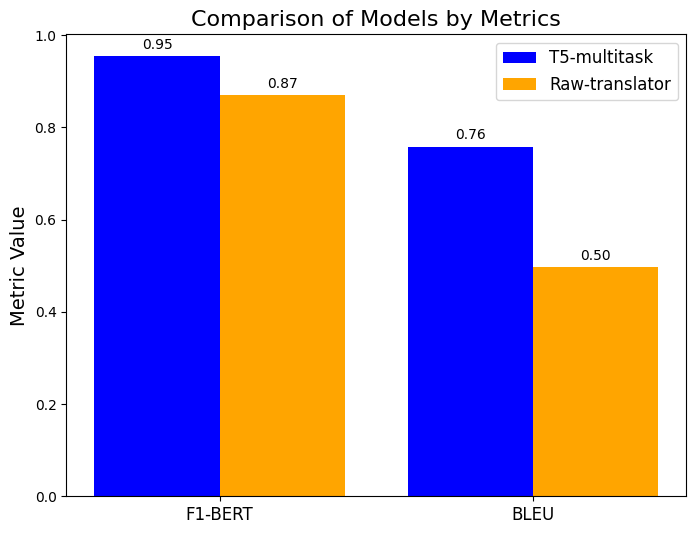

In [169]:
metrics = ["F1-BERT", "BLEU"]
T5_model = [T5_F1.mean().item(), T5_BLEU] 
raw_model = [raw_F1.mean().item(), raw_BLEU]

x = np.arange(len(metrics)) 
width = 0.4 

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width / 2, T5_model, width, label="T5-multitask", color='blue')
bars2 = ax.bar(x + width / 2, raw_model, width, label="Raw-translator", color='orange')

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Metric Value", fontsize=14)
ax.set_title("Comparison of Models by Metrics", fontsize=16)

ax.legend(fontsize=12)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Сдвиг текста вверх
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()